# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from matplotlib.gridspec import GridSpec

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
X_train, y_train = train['X'], train['y']
X_test, y_test = test['X'], test['y']

y_train, y_test = y_train.reshape(-1,), y_test.reshape(-1,)
y_train[y_train==10] = 0
y_test[y_test==10] = 0

X_train.shape, y_train.shape

((32, 32, 3, 73257), (73257,))

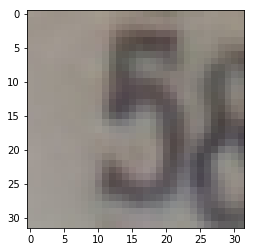

Image 28 label: 5


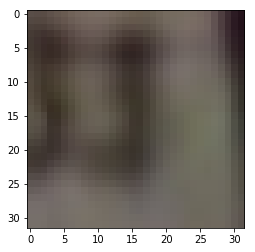

Image 11 label: 3


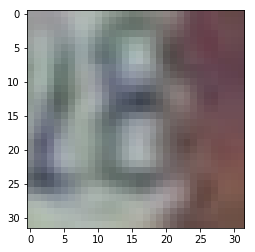

Image 19 label: 8


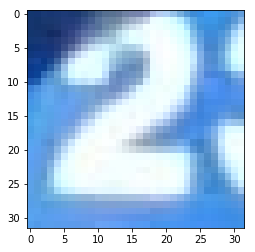

Image 2 label: 2


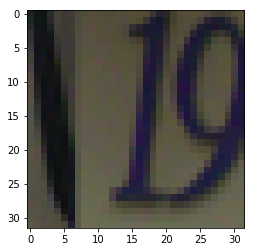

Image 0 label: 1


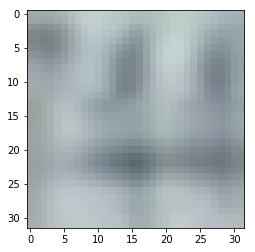

Image 15 label: 4


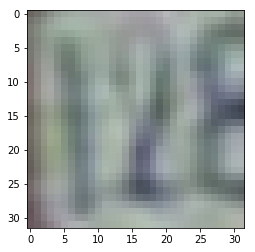

Image 18 label: 2


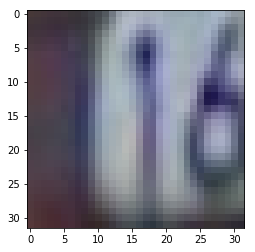

Image 20 label: 1


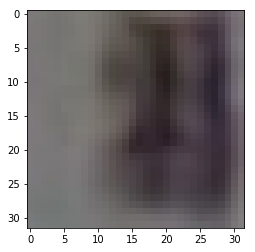

Image 22 label: 2


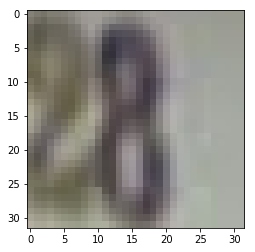

Image 13 label: 8


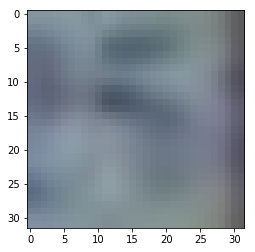

Image 5 label: 5


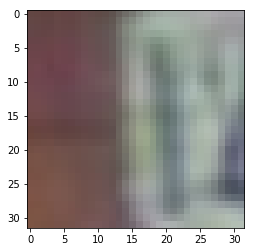

Image 17 label: 1


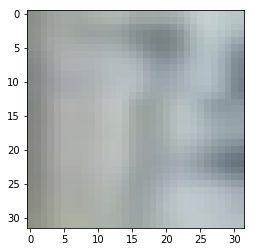

Image 14 label: 7


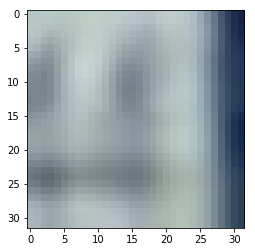

Image 16 label: 4


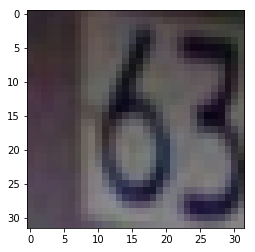

Image 24 label: 6


In [4]:
# Display images with their label

num_img_to_display = 15
indx_to_display = random.sample(range(0, len(X_train)), num_img_to_display)   

for i in indx_to_display:
    plt.imshow(X_train[:, :, :, i])
    plt.show()
    print(f'Image {i} label: {y_train[i]}')


In [5]:
# Convert RGB to grayscale

def rgb2gray(data):
    
    def rgb2gray_img(rgb):
        return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
    
    gray_img = []
    
    for i in range(data.shape[3]):
        gray = rgb2gray_img(data[:, :, :, i])
        gray_img.append(gray)
        
    return np.array(gray_img)[..., np.newaxis]

X_train_gray, X_test_gray = rgb2gray(X_train), rgb2gray(X_test)

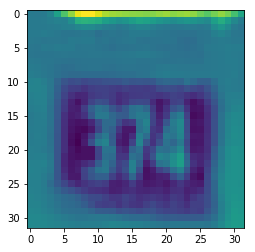

Image 13023 label: 7


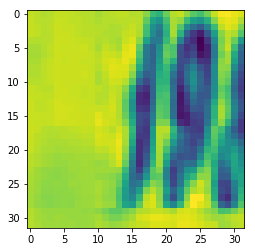

Image 29988 label: 1


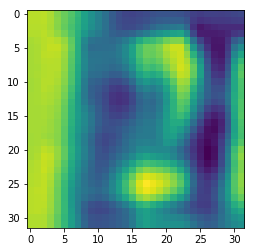

Image 25131 label: 2


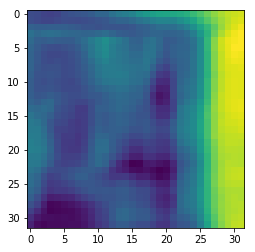

Image 26644 label: 4


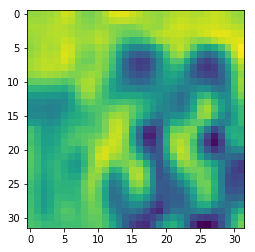

Image 46691 label: 3


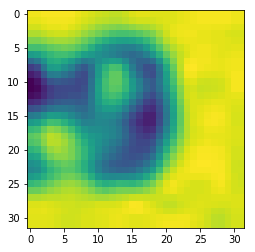

Image 58754 label: 9


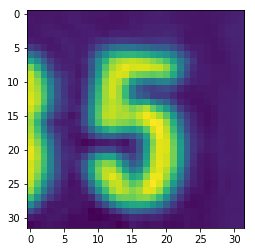

Image 49581 label: 5


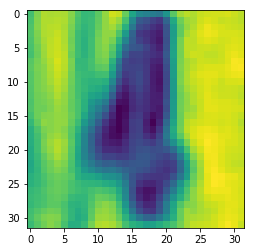

Image 37648 label: 4


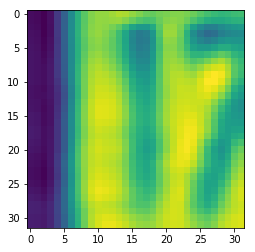

Image 47323 label: 1


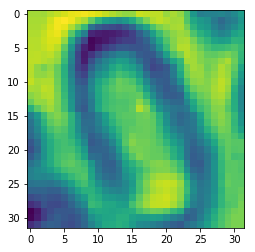

Image 30751 label: 0


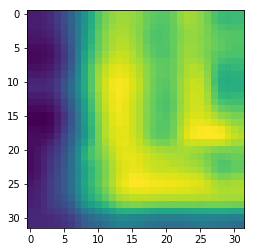

Image 20718 label: 1


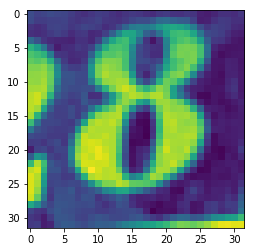

Image 57438 label: 8


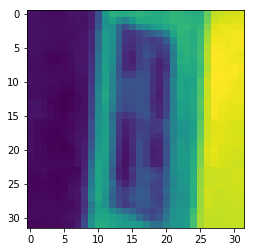

Image 44018 label: 1


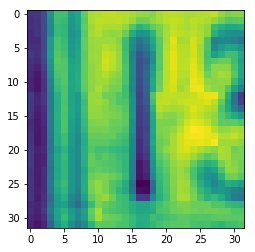

Image 36813 label: 1


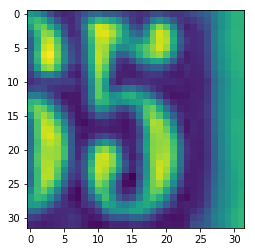

Image 40594 label: 5


In [6]:
# Display grayscale images with their label

num_img_to_display = 15
indx_to_display = random.sample(range(0, len(X_train_gray)), num_img_to_display)   
size = X_train_gray[0].shape[0]

for i in indx_to_display:
    plt.imshow(X_train_gray[i].reshape(size, size))
    plt.show()
    print(f'Image {i} label: {y_train[i]}')

In [7]:
X_train_gray = X_train_gray / 255
X_test_gray = X_test_gray / 255

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [64]:
# Build a neural network and compile it

def get_mlp_model(input_shape, lr):
    
    initializer = tf.keras.initializers.he_uniform()
    model = Sequential([
        Flatten(name='flatten', input_shape=input_shape),
        Dense(128, activation='relu', name='dense_1', kernel_regularizer=l2(lr)),
        Dense(64, activation='relu', name='dense_2', kernel_regularizer=l2(lr)),
        Dense(32, activation='relu', name='dense_3', kernel_regularizer=l2(lr)),
        Dense(10, activation='softmax', name='dense_5')
    ])
    
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [65]:
# Evaluate the trained model on test set

def get_test_accuracy(model, x_test, y_test):

    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {loss:0.3f}'.format(loss=test_loss))

In [66]:
# Save the weights after each epoch

def get_checkpoint_every_epoch(filepath):

    checkpoint_every_epoch = ModelCheckpoint(filepath=filepath,
                                             save_weights_only=True,
                                             save_freq='epoch', 
                                             verbose=1
                                            )
    
    return checkpoint_every_epoch


In [67]:
# Save the weights of the best performance 

def get_checkpoint_best_only(filepath):

    checkpoint_best_only = ModelCheckpoint(filepath=filepath,
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           verbose=1
                                          )
    return checkpoint_best_only

In [68]:
# Early stopping callback

def get_early_stopping():
    
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                  patience=5)
    
    return early_stopping

In [69]:
model_mlp = get_mlp_model(X_train_gray[0].shape, 1e-3)
model_mlp.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________


In [70]:
checkpoint_mlp_every_epoch = get_checkpoint_every_epoch('checkpoints_mlp_every_epoch/checkpoint_{epoch:03d}')
checkpoint_mlp_best_only = get_checkpoint_best_only('checkpoints_mlp_best_only/checkpoint')
early_stopping = get_early_stopping()

callbacks = [checkpoint_mlp_every_epoch, checkpoint_mlp_best_only, early_stopping]
history = model_mlp.fit(X_train_gray, y_train, epochs=30, batch_size=32, 
          validation_split=0.15, callbacks=callbacks)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62176/62268 [============================>.] - ETA: 0s - loss: 2.1360 - accuracy: 0.2610
Epoch 00001: saving model to checkpoints_mlp_every_epoch/checkpoint_001

Epoch 00001: val_accuracy improved from -inf to 0.36882, saving model to checkpoints_mlp_best_only/checkpoint
62268/62268 [==============================] - 38s 603us/sample - loss: 2.1353 - accuracy: 0.2612 - val_loss: 1.8035 - val_accuracy: 0.3688
Epoch 2/30
62208/62268 [============================>.] - ETA: 0s - loss: 1.6158 - accuracy: 0.4683
Epoch 00002: saving model to checkpoints_mlp_every_epoch/checkpoint_002

Epoch 00002: val_accuracy improved from 0.36882 to 0.49449, saving model to checkpoints_mlp_best_only/checkpoint
62268/62268 [==============================] - 37s 593us/sample - loss: 1.6158 - accuracy: 0.4682 - val_loss: 1.5625 - val_accuracy: 0.4945
Epoch 3/30
62176/62268 [============================>.] - ETA: 0s - loss: 1.4610 - accuracy: 0.5412
E

Epoch 22/30
62144/62268 [============================>.] - ETA: 0s - loss: 1.0271 - accuracy: 0.7304
Epoch 00022: saving model to checkpoints_mlp_every_epoch/checkpoint_022

Epoch 00022: val_accuracy did not improve from 0.74547
62268/62268 [==============================] - 36s 578us/sample - loss: 1.0271 - accuracy: 0.7304 - val_loss: 1.0902 - val_accuracy: 0.7032
Epoch 23/30
62208/62268 [============================>.] - ETA: 0s - loss: 1.0135 - accuracy: 0.7340
Epoch 00023: saving model to checkpoints_mlp_every_epoch/checkpoint_023

Epoch 00023: val_accuracy did not improve from 0.74547
62268/62268 [==============================] - 36s 575us/sample - loss: 1.0135 - accuracy: 0.7339 - val_loss: 1.0215 - val_accuracy: 0.7342
Epoch 24/30
62112/62268 [============================>.] - ETA: 0s - loss: 1.0119 - accuracy: 0.7354
Epoch 00024: saving model to checkpoints_mlp_every_epoch/checkpoint_024

Epoch 00024: val_accuracy did not improve from 0.74547
62268/62268 [====================

In [71]:
def accuracy_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 

In [72]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 

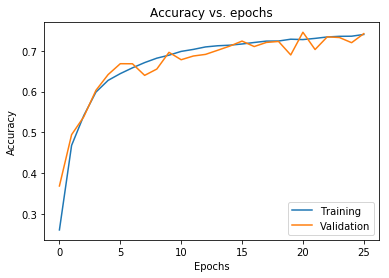

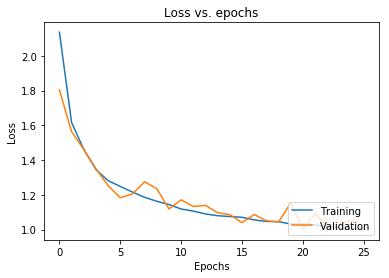

accuracy: 0.724
loss: 1.086


In [73]:
accuracy_plot(history)
loss_plot(history)
get_test_accuracy(model_mlp, X_test_gray, y_test)

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [74]:
# build a neural network and compile it

def get_cnn_model(input_shape, dropout, lr):
    
    initializer = tf.keras.initializers.he_uniform()
    model = Sequential([
        Conv2D(8, kernel_size=(3, 3), activation="relu", padding="SAME", 
               kernel_initializer=initializer, name="conv_1", input_shape=input_shape),
        Conv2D(8, kernel_size=(3, 3), activation="relu", padding="SAME", name="conv_2"),
        MaxPooling2D(pool_size=(8, 8), name='pool_1'),
        Flatten(name='flatten'),
        BatchNormalization(),
        Dense(64, activation='relu', name='dense_1', kernel_regularizer=l2(lr)),
        Dropout(dropout),
        Dense(32, activation='relu', name='dense_2', kernel_regularizer=l2(lr)),
        Dropout(dropout),
        Dense(10, activation='softmax', name='dense_3')
    ])
    
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [75]:
model_cnn = get_cnn_model(X_train_gray[0].shape, 0.2, 1e-3)
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 8)         80        
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 8)         584       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [76]:
checkpoint_cnn_every_epoch = get_checkpoint_every_epoch('checkpoints_cnn_every_epoch/checkpoint_{epoch:03d}')
checkpoint_cnn_best_only = get_checkpoint_best_only('checkpoints_cnn_best_only/checkpoint')
early_stopping = get_early_stopping()

callbacks = [checkpoint_cnn_every_epoch, checkpoint_cnn_best_only, early_stopping]
history = model_cnn.fit(X_train_gray, y_train, epochs=30, batch_size=32, 
          validation_split=0.15, callbacks=callbacks)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.5974 - accuracy: 0.4903
Epoch 00001: saving model to checkpoints_cnn_every_epoch/checkpoint_001

Epoch 00001: val_accuracy improved from -inf to 0.71162, saving model to checkpoints_cnn_best_only/checkpoint
62268/62268 [==============================] - 258s 4ms/sample - loss: 1.5973 - accuracy: 0.4904 - val_loss: 1.0013 - val_accuracy: 0.7116
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.0568 - accuracy: 0.6905
Epoch 00002: saving model to checkpoints_cnn_every_epoch/checkpoint_002

Epoch 00002: val_accuracy improved from 0.71162 to 0.76777, saving model to checkpoints_cnn_best_only/checkpoint
62268/62268 [==============================] - 251s 4ms/sample - loss: 1.0567 - accuracy: 0.6906 - val_loss: 0.8309 - val_accuracy: 0.7678
Epoch 3/30
62240/62268 [============================>.] - ETA: 0s - loss: 0.9691 - accuracy: 0.7195
Epo

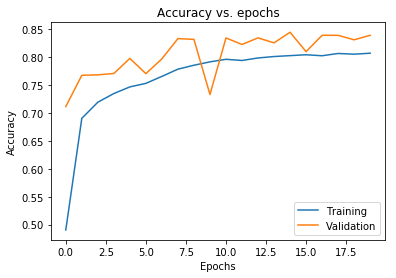

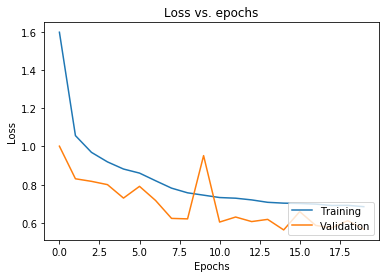

accuracy: 0.824
loss: 0.636


In [77]:
accuracy_plot(history)
loss_plot(history)
get_test_accuracy(model_cnn, X_test_gray, y_test)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [78]:
def get_model_best_epoch(model, filepath):
    """
    This function should create a new instance of the CNN you created earlier, load 
    on the weights leading to the highest validation accuracy, and return this model.
    """
    
    model.load_weights(tf.train.latest_checkpoint(filepath))
    
    return model

In [79]:
model_best_mlp = get_model_best_epoch(get_mlp_model(X_train_gray[0].shape, 1e-3), 'checkpoints_mlp_best_only')
model_best_cnn = get_model_best_epoch(get_cnn_model(X_train_gray[0].shape, 0.2, 1e-3), 'checkpoints_cnn_best_only')

In [81]:
prediction_mlp = model_best_mlp.predict(X_test_gray)
prediction_cnn = model_best_cnn.predict(X_test_gray)

Image no.14091 label: 5


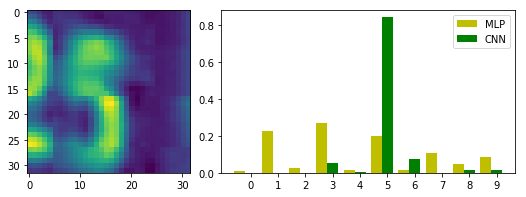

Image no.2916 label: 3


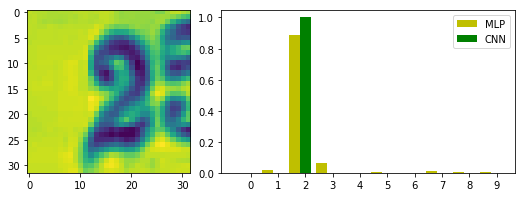

Image no.1912 label: 3


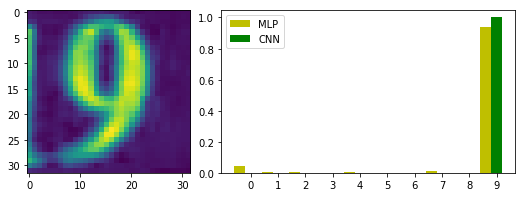

Image no.24958 label: 7


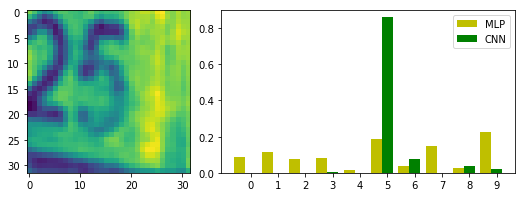

Image no.16871 label: 1


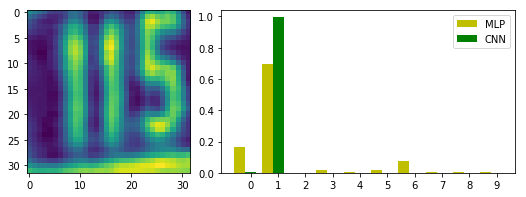

In [82]:
# display grayscale images with their label

num_img_to_display = 5
indx_to_display = random.sample(range(0, len(X_test_gray)), num_img_to_display)   
size = X_test_gray[0].shape[0]

for i in indx_to_display:
    
    print(f'Image no.{i} label: {y_train[i]}')
    
    plt.figure(figsize=(9,3))
    gs = GridSpec(1,5)
    
    plt.subplot(gs[0,:2])
    plt.imshow(X_test_gray[i].reshape(size, size))
    
    plt.subplot(gs[0, 2:])
    name_list = range(10)
    mlp_list = prediction_mlp[i]
    cnn_list = prediction_cnn[i]
    x =list(range(len(name_list)))
    total_width, n = 0.8, 2
    width = total_width / n

    plt.bar(x, mlp_list, width=width, label='MLP',fc='y')
    for i in range(len(x)):
        x[i] = x[i] + width
    plt.bar(x, cnn_list, width=width, label='CNN', tick_label=name_list, fc='green')
    plt.legend()
    
    plt.show()
